<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="https://mng.bz/lZ5B">Build a Reasoning Model (From Scratch)</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/reasoning-from-scratch">https://github.com/rasbt/reasoning-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="https://mng.bz/lZ5B"><img src="https://sebastianraschka.com/images/reasoning-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Chapter 7: Exercise Solutions

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

used_libraries = [
    "reasoning_from_scratch",
    "torch",
    "tokenizers"  # Used by reasoning_from_scratch
]

for lib in used_libraries:
    print(f"{lib} version: {version(lib)}")

reasoning_from_scratch version: 0.1.15
torch version: 2.10.0
tokenizers version: 0.22.2


&nbsp;
## Exercise 7.1: Testing the `<think>` format reward

- The following code checks that the format reward is zero if the think tokens are used incorrectly

In [2]:
from pathlib import Path
from reasoning_from_scratch.qwen3 import Qwen3Tokenizer
from reasoning_from_scratch.qwen3 import download_qwen3_small

download_qwen3_small(
    kind="reasoning", tokenizer_only=True, out_dir="qwen3"
)

tokenizer_path = Path("qwen3") / "tokenizer-reasoning.json"
tokenizer = Qwen3Tokenizer(tokenizer_file_path=tokenizer_path)

✓ qwen3/tokenizer-reasoning.json already up-to-date


In [3]:
import torch
from reasoning_from_scratch.ch07 import reward_format

prompt = "Calculate ..."

def check_case(name, rollout):
    token_ids = tokenizer.encode(prompt + rollout)
    prompt_len = len(tokenizer.encode(prompt))

    reward = reward_format(
        token_ids=torch.tensor(token_ids),
        prompt_len=prompt_len,
    )

    print(f"{name}: {reward}")


# 1) Correct case
check_case(
    "Correct order",
    "Let's ... <think> ... </think> ..."
)

# 2) Typo in tag
check_case(
    "Typo in <think>",
    "Let's ... <thnik> ... </think> ..."
)

# 3) Reversed order
check_case(
    "Reversed order",
    "Let's ... </think> ... <think> ..."
)

# 4) Missing one tag
check_case(
    "Missing </think>",
    "Let's ... <think> ..."
)

Correct order: 1.0
Typo in <think>: 0.0
Reversed order: 0.0
Missing </think>: 0.0


- The output indicates that the function requires correct <think>...</think> tag use to award a reward of 1.0

&nbsp;
## Exercise 7.2: Conditional format rewards

- The implementation of the conditional reward is very simple; in the main chapter, we discussed implementing the overall reward as follows:

```python
reward = rlvr_reward + format_reward_weight * format_reward
```

- So, one way to disable the reward if the correctness reward (`rlvr_reward`) is 0.0 is

```python
if conditional_reward:
    format_reward *= rlvr_reward
reward = rlvr_reward + format_reward_weight * format_reward
```

- To use it in practice, you can run the [03_rlvr_grpo_scripts_advanced/7_6_plus_format_reward.py](./03_rlvr_grpo_scripts_advanced/7_6_plus_format_reward.py) script (similar to section 7.6 in chapter 7) with the `--conditional_reward` flag enabled
- To analyze the results, let's first plot the original results from chapter 7.6 again without conditional rewards for reference:

In [4]:
from reasoning_from_scratch.ch07 import download_from_github

download_from_github(
    "ch07/02_logs/7_6_plus_format_reward_metrics.csv"
)

7_6_plus_format_reward_metrics.csv: 51.7 KB (cached)


PosixPath('7_6_plus_format_reward_metrics.csv')

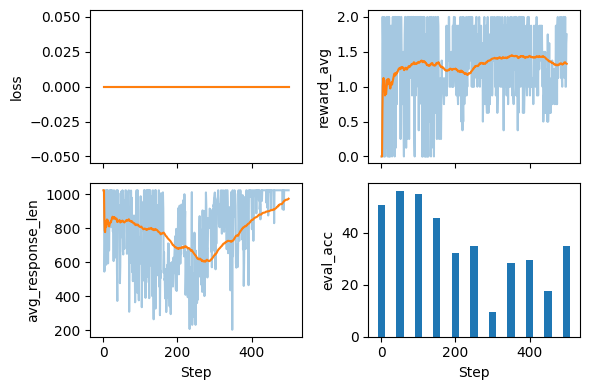

In [5]:
from reasoning_from_scratch.ch07 import plot_grpo_metrics

plot_grpo_metrics(
    "7_6_plus_format_reward_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
)

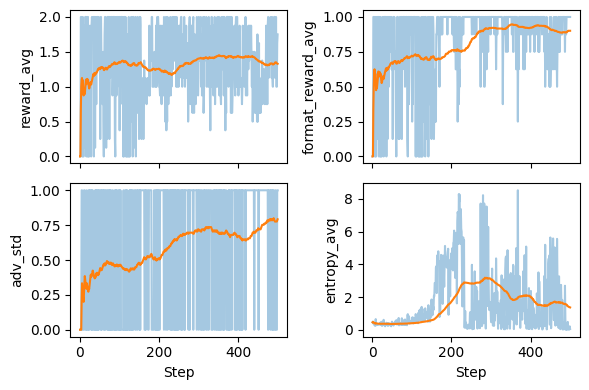

In [6]:
plot_grpo_metrics(
    "7_6_plus_format_reward_metrics.csv",
    columns=["reward_avg", "format_reward_avg", "adv_std", "entropy_avg"],
)

- Next, let's look at the training runs with the conditional rewards enabled:

In [7]:
download_from_github(
    "ch07/02_logs/7_6_plus_format_reward_conditional_metrics.csv"
)

7_6_plus_format_reward_conditional_metrics.csv: 51.6 KB (cached)


PosixPath('7_6_plus_format_reward_conditional_metrics.csv')

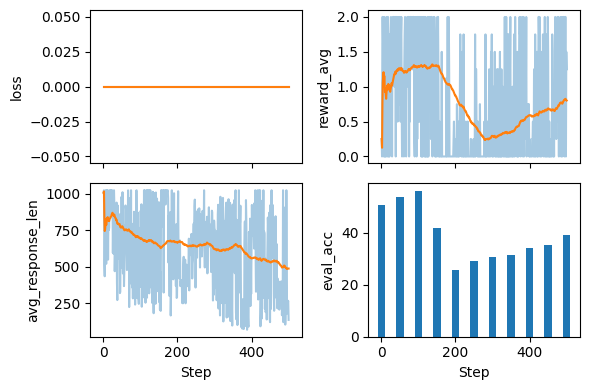

In [8]:
plot_grpo_metrics(
    "7_6_plus_format_reward_conditional_metrics.csv",
    columns=["loss", "reward_avg", "avg_response_len", "eval_acc"],
    #save_as="ex07-1.pdf"
)

- The evaluation accuracy and reward average take a big hit, but seem to recover
- Overall, despite this performance crash, this looks more stable than before, and the trend indicates that the performance would improve further if we trained longer

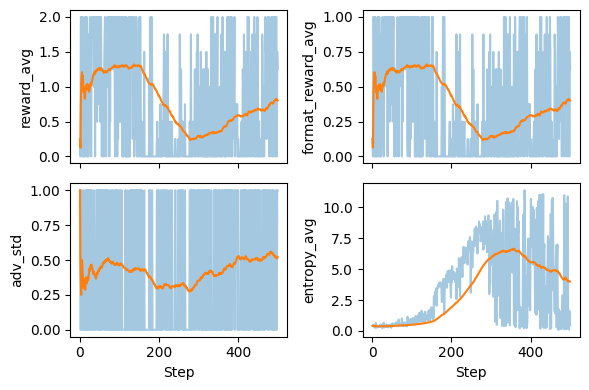

In [9]:
plot_grpo_metrics(
    "7_6_plus_format_reward_conditional_metrics.csv",
    columns=["reward_avg", "format_reward_avg", "adv_std", "entropy_avg"],
    # save_as="ex07-2.pdf"
)

- Here, we see the average format reward mimicking the average reward graph almost perfectly, which is a good sanity check that the conditional logic is working
- Also, the average format reward shows how much of the total reward is coming from the format term on the subset of correct answers
- As we can see though, since the average format reward graph echoes the average reward one, it's mainly a bonus (and it looks like it's always awarded if the model is correct; this makes sense, because the trained reasoning model already knows how to use `<think>...</think>` tags correctly (and we can see that it doesn't unlearn this ability)
- The entropy increase is still a bit troubling, though, and could hint towards training instabilities that could potentially be addressed by other means (like tighter clipping with smaller `clip_eps`)